# EDA 

- 현재 CV Score 하고 LB Score가 차이나는 이유를 Feature 분포에서 체크
- 의미있는 Feature 찾기

## 사용 Feature

- SplitAssessmentItemID,
- ConvertTime,
- MakeFirstClass,
- MakeSecondClass,
- [x] MakeCorrectCount,
- [x] MakeQuestionCount,
- [x] MakeCorrectPercent,
- [x] MakeDifficultyByFirstClass

체크된 4개가 적용된 후의 분포 확인해야 될 것들

## Prepare

In [1]:
import sys
sys.path.append("..")

import os.path as p
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fe.seq import SeqFeBase
from fe.agg import AggFeBase

In [2]:
train_data = pd.read_csv("../../input/data/train_dataset/train_data.csv") 
test_data = pd.read_csv("../../input/data/train_dataset/test_data.csv")

## 비슷한 Sequence 있는지 찾아보기

- Vector로 바꾼 이후로 Clustering 하여 판단..
- 코드가 길어질 것 같아서 10-Clustering Sequnce에서 작성 

### MakeCorrectCount

In [3]:
class MakeCorrectCount(AggFeBase):
    name = "make_correct_count"
    description = {"correctCnt": "사용자가 맞춘 문항수를 나타냅니다."}

    @classmethod
    def _transform(cls, df):
        """ 사용자가 맞춘 문항수를 만듭니다. """
        grouped_df = df.groupby("userID").sum()
        right_df = pd.DataFrame({"userID": list(grouped_df.index), "correctCnt": list(grouped_df.answerCode)})
        return right_df

## 시험지별 난이도 비교하기

In [192]:
tdf = SplitAssessmentItemID.transform(train_data, key="tdf")
vdf = SplitAssessmentItemID.transform(test_data, key="vdf")

save features dataframe to /home/j-gunmo/features/tdf_split_assessmentitem_id.pkl ...
save features dataframe to /home/j-gunmo/features/vdf_split_assessmentitem_id.pkl ...


In [193]:
len(tdf.testPaper.unique()), len(vdf.testPaper.unique())

(1537, 1537)

In [194]:
# 시험지하고 문제는 다 겹친다.
len(set(tdf.testPaper.unique()).intersection(set(vdf.testPaper.unique())))

1537

In [197]:
test_per = dict(tdf.groupby("testPaper").answerCode.mean())

In [209]:
c = vdf[vdf.answerCode == -1]['testPaper'].apply(lambda x: test_per[x])

In [210]:
# 테스트에 시험지가 411개 밖에 없네..?

len(vdf[vdf.answerCode == -1]['testPaper'].unique())

411

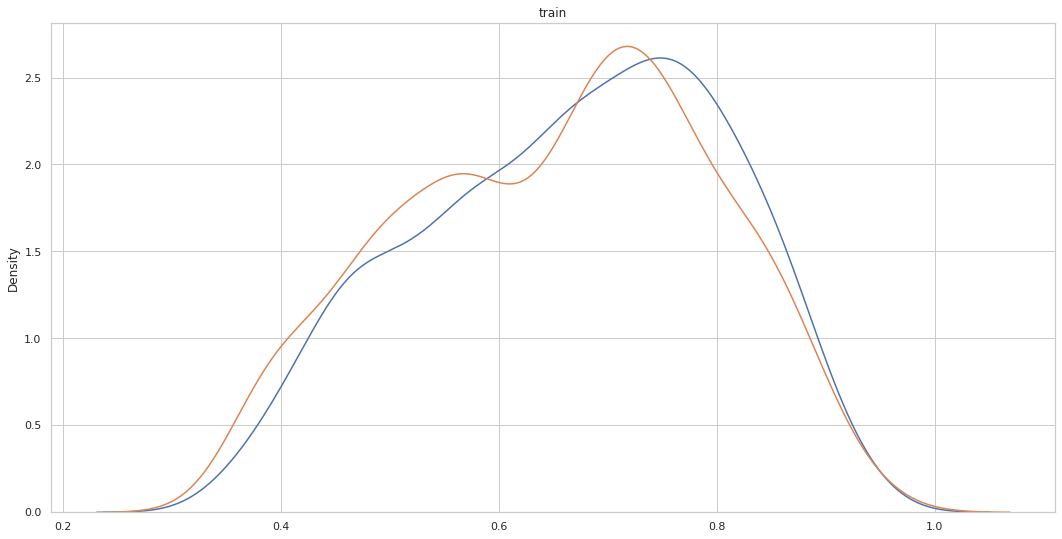

In [211]:
fig, axes = plt.subplots(1, 1, figsize=(18, 9))

axes.set_title("train")

sns.kdeplot(x=list(test_per.values()), ax=axes)
sns.kdeplot(x=list(c), ax=axes)
plt.show()

- train 문항 수
- test 문항 수

In [6]:
tr_cor = MakeCorrectCount._transform(train_data)
te_cor = MakeCorrectCount._transform(test_data)

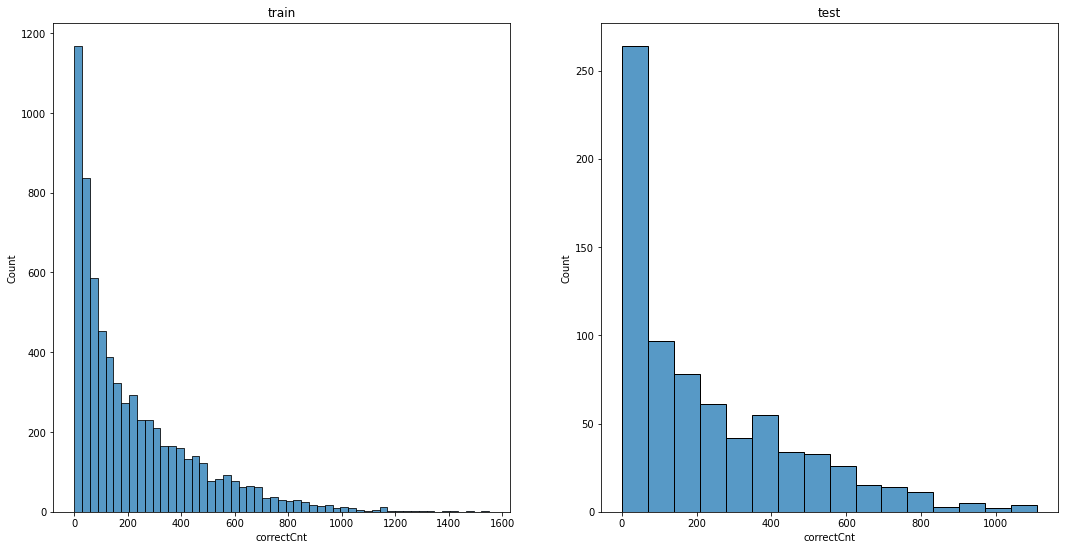

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].set_title("train")
axes[1].set_title("test")

sns.histplot(data=tr_cor, x="correctCnt", ax=axes[0])
sns.histplot(data=te_cor, x="correctCnt", ax=axes[1])
plt.show()

## MakeQuestionCount

In [6]:
class MakeQuestionCount(AggFeBase):
    name = "make_question_count"
    description = {"quesCnt": "사용자가 푼 문항수를 나타냅니다."}

    @classmethod
    def _transform(cls, df):
        """ 사용자가 푼 문항수를 만듭니다. """
        right_df = pd.DataFrame(df.groupby("userID").size(), columns=["quesCnt"]).reset_index()
        return right_df

In [25]:
tr_que = MakeQuestionCount._transform(train_data)
te_que = MakeQuestionCount._transform(test_data)

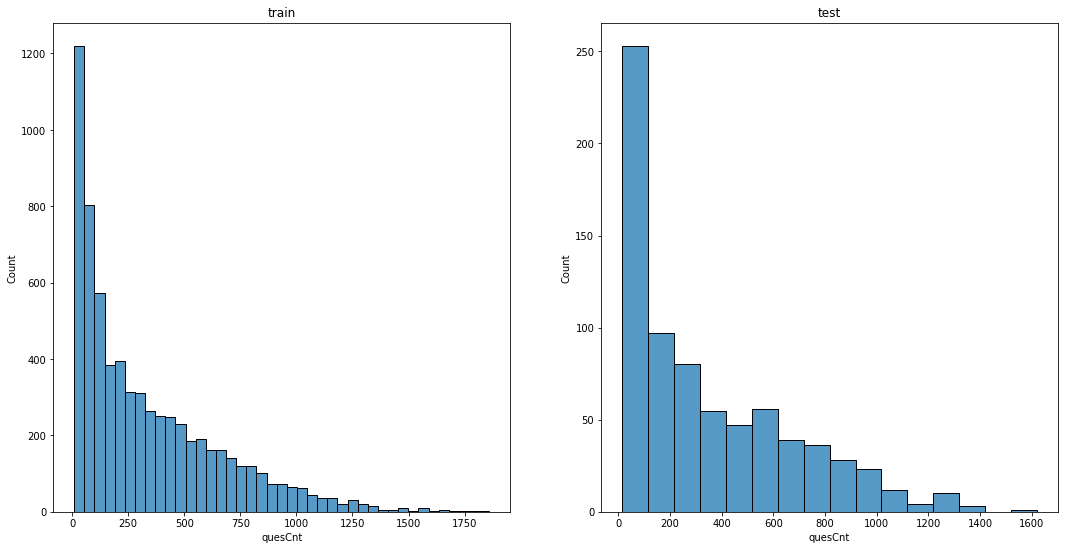

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].set_title("train")
axes[1].set_title("test")

sns.histplot(data=tr_que, x="quesCnt", ax=axes[0])
sns.histplot(data=te_que, x="quesCnt", ax=axes[1])
plt.show()

## MakeCorrectPercent

In [7]:
class MakeCorrectPercent(AggFeBase):
    name = "make_correct_percent"
    pre_fe = {"make_question_count", "make_correct_count"}
    description = {"correctPer": "사용자가 푼 전체 문항에 대한 정답률입니다."}

    @classmethod
    def _transform(cls, df):
        """ 사용자의 정답률을 만듭니다. """
        grouped_df = df.groupby("userID").mean()
        right_df = pd.DataFrame(
            {"userID": list(grouped_df.index), "correctPer": list(grouped_df.correctCnt / grouped_df.quesCnt)}
        )
        return right_df

In [44]:
tr_per, te_per = pd.DataFrame([]), pd.DataFrame([])
tr_per["userID"] = tr_que["userID"]
te_per["userID"] = te_que["userID"]

tr_per["correctPer"] = tr_cor["correctCnt"] / tr_que["quesCnt"]
te_per["correctPer"] = te_cor["correctCnt"] / te_que["quesCnt"]

In [45]:
tr_per.sort_values(by=["correctPer"], inplace=True)
te_per.sort_values(by=["correctPer"], inplace=True)

<AxesSubplot:ylabel='correctPer'>

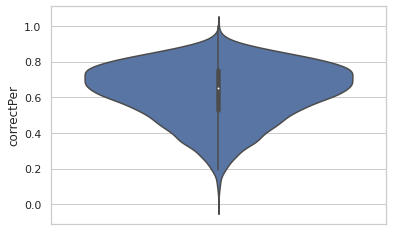

In [174]:
sns.violinplot(data=tr_per, y="correctPer")

<AxesSubplot:ylabel='correctPer'>

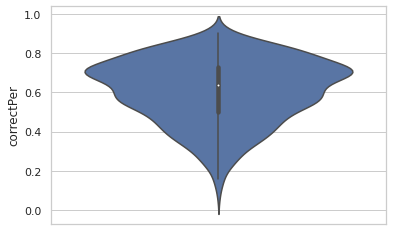

In [175]:
sns.violinplot(data=te_per, y="correctPer")

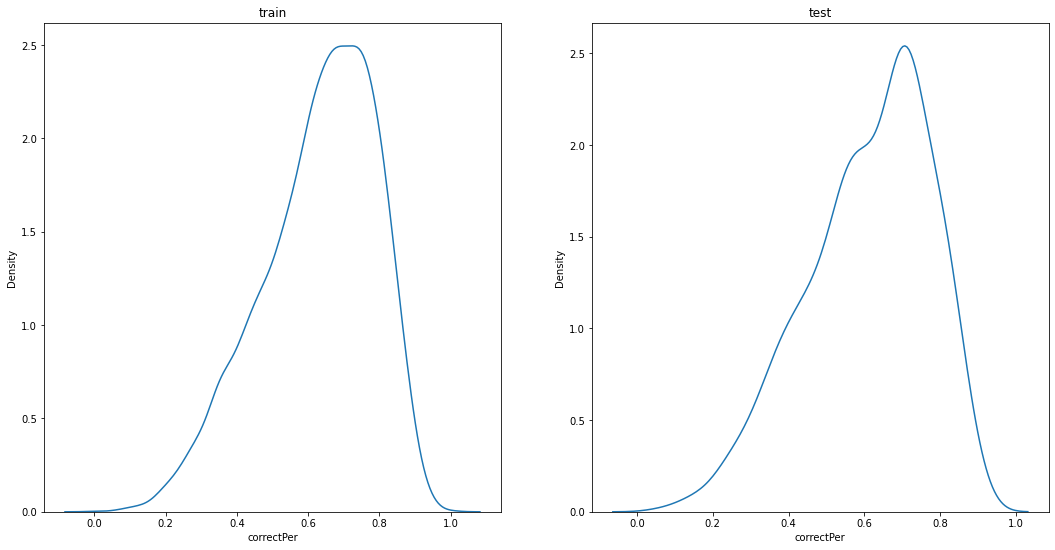

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].set_title("train")
axes[1].set_title("test")

sns.kdeplot(data=tr_per, x="correctPer", ax=axes[0])
sns.kdeplot(data=te_per, x="correctPer", ax=axes[1])
plt.show()

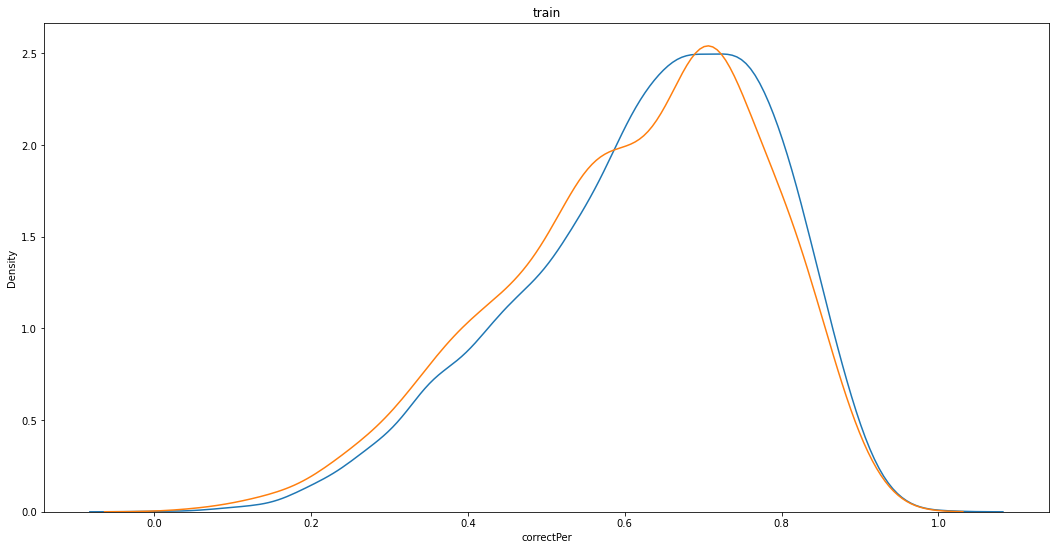

In [95]:
fig, axes = plt.subplots(1, 1, figsize=(18, 9))

axes.set_title("train")

sns.kdeplot(data=tr_per, x="correctPer", ax=axes)
sns.kdeplot(data=te_per, x="correctPer", ax=axes)
plt.show()

In [50]:
len(tr_per), len(te_per)

(6698, 744)

## MakeDiffcultyByFirstClass

- 유저의 대분류별 정답률을 나타내서 문제가 됐던 것 같다..
- 대분류별 정답률이 중요한건데

In [4]:
class MakeDifficultyByFirstClass(AggFeBase):
    name = "make_difficulty_by_firstclass"
    description = {
        "firstClassDifficulty" : "유저의 대분류별 정답률을 나타냅니다."
    }
    
    pre_fe = {"make_first_class"}
    agg_column = ["userID", "firstClass"]
    
    @classmethod
    def _transform(cls, df):
        grouped_df = df.groupby(cls.agg_column).answerCode.mean()
        a, b = zip(*grouped_df.index)
        
        right_df = pd.DataFrame(
            {"userID": a, "firstClass": b, "firstClassDifficulty": list(grouped_df)}
        )
        
        return right_df

In [67]:
valid_test_data = test_data[test_data["answerCode"] != -1]

In [68]:
from fe.seq import SplitAssessmentItemID, MakeFirstClass
tr_data = MakeFirstClass.transform(train_data, key="ttr")
te_data = MakeFirstClass.transform(valid_test_data, key="tte")

save features dataframe to /home/j-gunmo/features/ttr_make_first_class.pkl ...
save features dataframe to /home/j-gunmo/features/tte_make_first_class.pkl ...


In [69]:
tr_data = MakeDifficultyByFirstClass.transform(tr_data, key="ttr")
te_data = MakeDifficultyByFirstClass.transform(te_data, key="tte")

save features dataframe to /home/j-gunmo/features/ttr_make_difficulty_by_firstclass.pkl ...
save features dataframe to /home/j-gunmo/features/tte_make_difficulty_by_firstclass.pkl ...


In [70]:
tr_data["label"] = "train"  
te_data["label"] = "test"

In [71]:
aug_test_dataset = test_data[test_data["answerCode"] != -1]
total_dataset = pd.concat([train_data, aug_test_dataset], axis=0)

total_dataset = MakeFirstClass.transform(total_dataset, key="ttt")
total_dataset = MakeDifficultyByFirstClass.transform(total_dataset, key="ttt")

save features dataframe to /home/j-gunmo/features/ttt_make_first_class.pkl ...
save features dataframe to /home/j-gunmo/features/ttt_make_difficulty_by_firstclass.pkl ...


In [72]:
total_dataset["label"] = "total"

In [123]:
total_dataset.userID.unique()

array([   0,    1,    2, ..., 7416, 7417, 7439])

In [129]:
total_dataset[(total_dataset['userID'] == 7416) & (total_dataset['firstClass'] == '8')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,firstClass,firstClassDifficulty,label
2525913,7416,A080002001,A080000002,1,2020-01-10 02:06:14,4605,8,0.5,total
2525914,7416,A080002002,A080000002,1,2020-01-10 02:06:17,1394,8,0.5,total
2525915,7416,A080002003,A080000002,0,2020-01-10 02:09:12,1396,8,0.5,total
2525916,7416,A080002004,A080000002,1,2020-01-10 02:09:31,1397,8,0.5,total
2525917,7416,A080002005,A080000002,0,2020-01-10 02:09:33,1396,8,0.5,total
2525918,7416,A080002006,A080000002,0,2020-01-10 02:09:36,1395,8,0.5,total


In [130]:
te_data[(te_data['userID'] == 7416) & (te_data['firstClass'] == '8')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,firstClass,firstClassDifficulty,label
259327,7416,A080002001,A080000002,1,2020-01-10 02:06:14,4605,8,0.5,test
259328,7416,A080002002,A080000002,1,2020-01-10 02:06:17,1394,8,0.5,test
259329,7416,A080002003,A080000002,0,2020-01-10 02:09:12,1396,8,0.5,test
259330,7416,A080002004,A080000002,1,2020-01-10 02:09:31,1397,8,0.5,test
259331,7416,A080002005,A080000002,0,2020-01-10 02:09:33,1396,8,0.5,test
259332,7416,A080002006,A080000002,0,2020-01-10 02:09:36,1395,8,0.5,test


In [137]:
total_dataset[(total_dataset['userID'] == 3) & (total_dataset['firstClass'] == '2')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,firstClass,firstClassDifficulty,label
2267447,3,A020027001,A020000027,1,2020-01-22 11:12:06,7912,2,0.87931,total
2267448,3,A020027002,A020000027,1,2020-01-22 11:13:37,7912,2,0.87931,total
2267449,3,A020027003,A020000027,1,2020-01-22 11:14:41,7912,2,0.87931,total
2267450,3,A020027004,A020000027,1,2020-01-22 11:14:58,7912,2,0.87931,total
2267451,3,A020027005,A020000027,1,2020-01-22 11:15:12,7912,2,0.87931,total
...,...,...,...,...,...,...,...,...,...
2267616,3,A020051001,A020000051,0,2020-04-21 12:02:00,7751,2,0.87931,total
2267617,3,A020051002,A020000051,0,2020-04-21 12:02:36,7751,2,0.87931,total
2267618,3,A020051003,A020000051,1,2020-04-21 12:04:10,7751,2,0.87931,total
2267619,3,A020051004,A020000051,1,2020-04-21 12:04:52,7751,2,0.87931,total


In [136]:
total_dataset[(total_dataset['userID'] == 3) & (total_dataset['firstClass'] == '2')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,firstClass,firstClassDifficulty,label
2267447,3,A020027001,A020000027,1,2020-01-22 11:12:06,7912,2,0.87931,total
2267448,3,A020027002,A020000027,1,2020-01-22 11:13:37,7912,2,0.87931,total
2267449,3,A020027003,A020000027,1,2020-01-22 11:14:41,7912,2,0.87931,total
2267450,3,A020027004,A020000027,1,2020-01-22 11:14:58,7912,2,0.87931,total
2267451,3,A020027005,A020000027,1,2020-01-22 11:15:12,7912,2,0.87931,total
...,...,...,...,...,...,...,...,...,...
2267616,3,A020051001,A020000051,0,2020-04-21 12:02:00,7751,2,0.87931,total
2267617,3,A020051002,A020000051,0,2020-04-21 12:02:36,7751,2,0.87931,total
2267618,3,A020051003,A020000051,1,2020-04-21 12:04:10,7751,2,0.87931,total
2267619,3,A020051004,A020000051,1,2020-04-21 12:04:52,7751,2,0.87931,total


In [73]:
tt_data = pd.concat([tr_data, te_data, total_dataset], axis=0)

In [74]:
sns.set_theme(style="whitegrid")

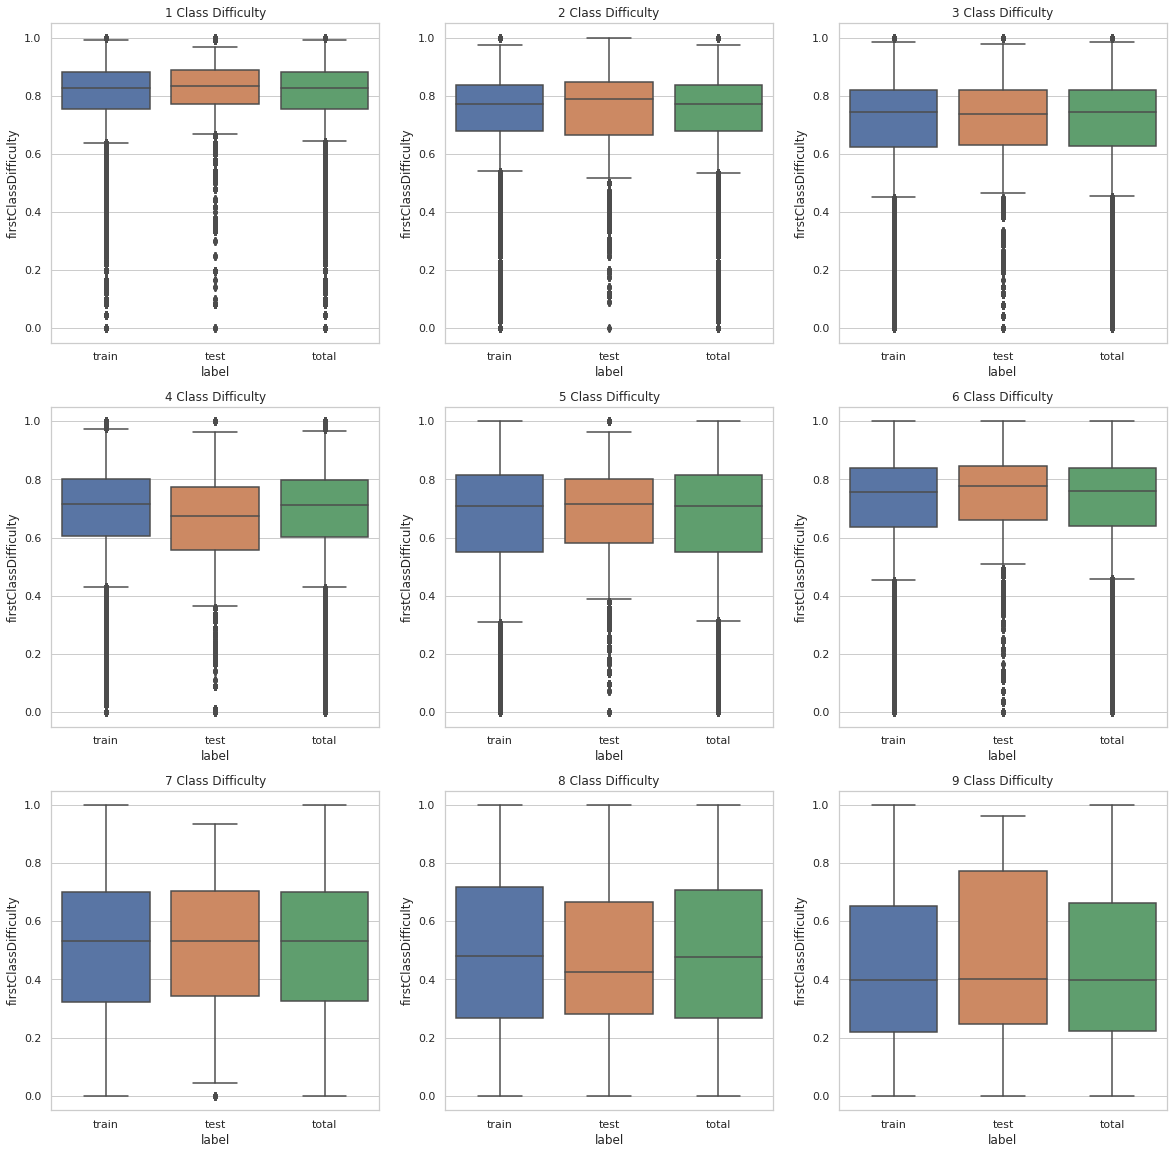

In [123]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for idx, g in enumerate(tt_data.groupby(["firstClass"])):
    axes[idx // 3][idx % 3].set_title(f"{idx+1} Class Difficulty")
    sns.boxplot(data=g[1], y="firstClassDifficulty", x="label", 
                ax=axes[idx // 3][idx % 3], whis=0.9)

In [13]:
minus_test_data = MakeFirstClass.transform(test_data, key="mtt")
minus_test_data = MakeDifficultyByFirstClass.transform(minus_test_data, key="mtt")

load features /home/j-gunmo/features/mtt_make_first_class.pkl to dataframe ... 
load features /home/j-gunmo/features/mtt_make_difficulty_by_firstclass.pkl to dataframe ... 


In [14]:
minus_test_data[minus_test_data.answerCode == -1]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,firstClass,firstClassDifficulty
861,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,5,0.653132
1577,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,7,0.699531
3023,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,7,0.387755
3965,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,9,0.920097
4618,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,6,0.811940
...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,4,0.000000
260067,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,3,0.200000
260082,7416,A050193004,A050000193,-1,2020-10-04 02:44:41,10402,5,0.250000
260097,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,0.250000


In [15]:
from collections import defaultdict

counter = defaultdict(int)

for g in minus_test_data.groupby(['userID', "firstClass"]):
    if list(g[1]['answerCode'])[-1] == -1:
        counter[g[0][1]] += 1

In [17]:
print(counter)

defaultdict(<class 'int'>, {'5': 83, '7': 123, '9': 19, '6': 66, '2': 87, '4': 97, '1': 75, '8': 109, '3': 85})


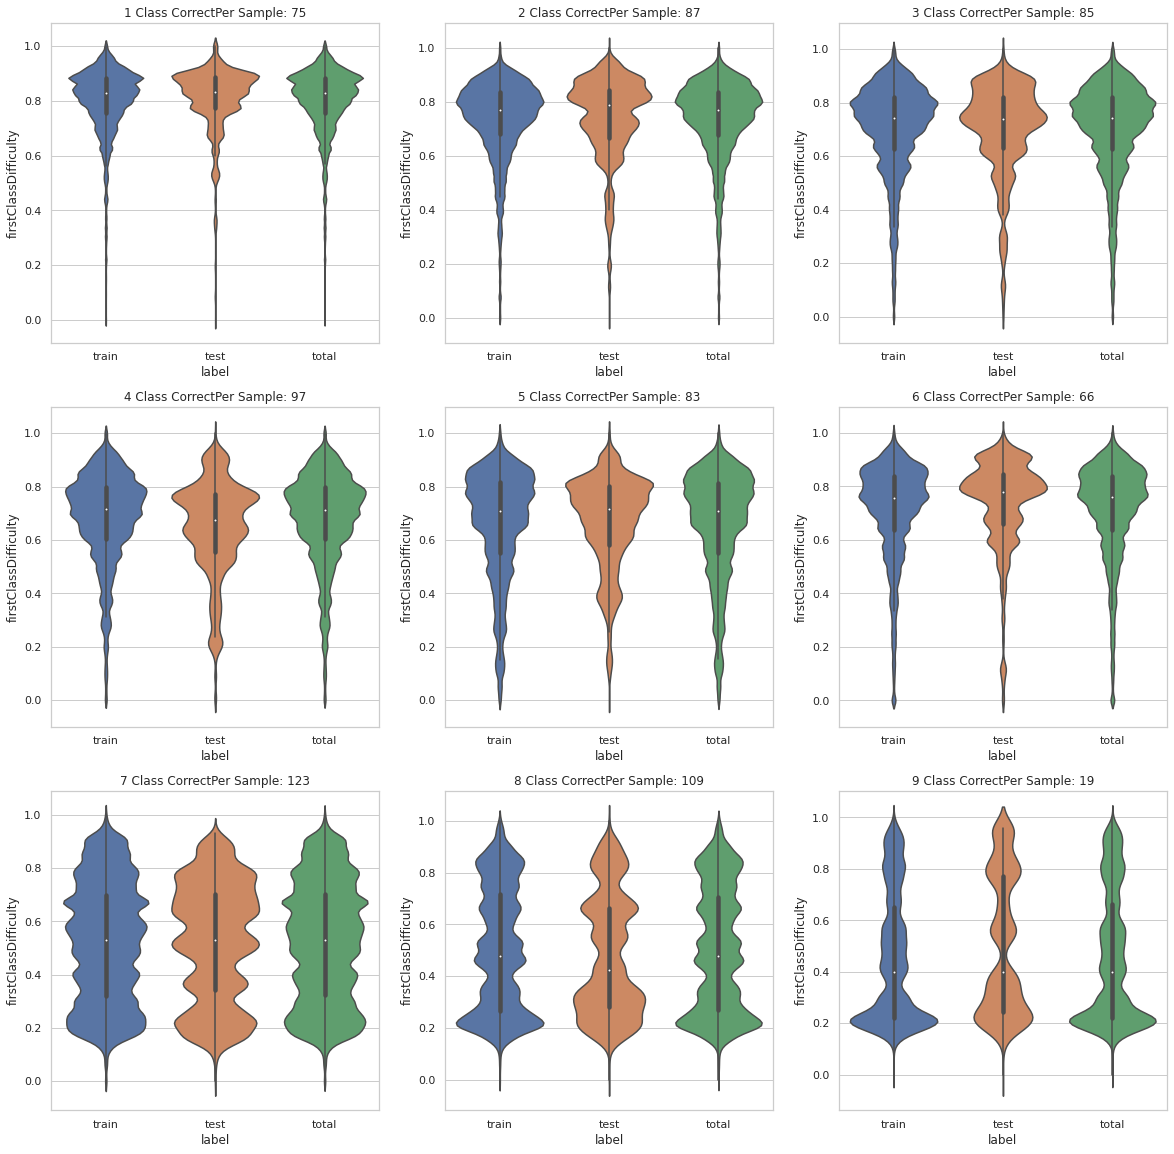

In [75]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for idx, g in enumerate(tt_data.groupby(["firstClass"])):
    axes[idx // 3][idx % 3].set_title(f"{idx+1} Class CorrectPer Sample: {counter[str(idx+1)]}")
    sns.violinplot(data=g[1], y="firstClassDifficulty", x="label", 
                ax=axes[idx // 3][idx % 3], whis=0.9)

## 문제별 난이도

- 문제의 총 개수는 9454개로 학습, 테스트 데이터셋에 모두 등장한다.
- 이거를 학습 데이터셋, 테스트 데이터셋에 다르게 적용하는 것이 옳을까?

In [9]:
class MakeDifficultyByAssessmentItem(AggFeBase):
    name = "make_difficulty_by_assessmentitem_id"
    description = {
        "problemDifficulty" : "문제의 전체 정답률(난이도)을 나타냅니다."
    }
    agg_column = ["assessmentItemID"]
    
    @classmethod
    def _transform(cls, df):
        grouped_df = df.groupby(cls.agg_column).answerCode.mean()
        right_df = pd.DataFrame({"assessmentItemID" : grouped_df.index, "problemDifficulty": list(grouped_df)})
        return right_df

In [190]:
len(train_data.assessmentItemID.unique()), len(test_data.assessmentItemID.unique())

(9454, 9454)

In [192]:
len(set(list(train_data.assessmentItemID) + list(test_data.assessmentItemID)))

9454

In [193]:
tr_diff_by_asses = MakeDifficultyByAssessmentItem._transform(train_data)
te_diff_by_asses = MakeDifficultyByAssessmentItem._transform(test_data)

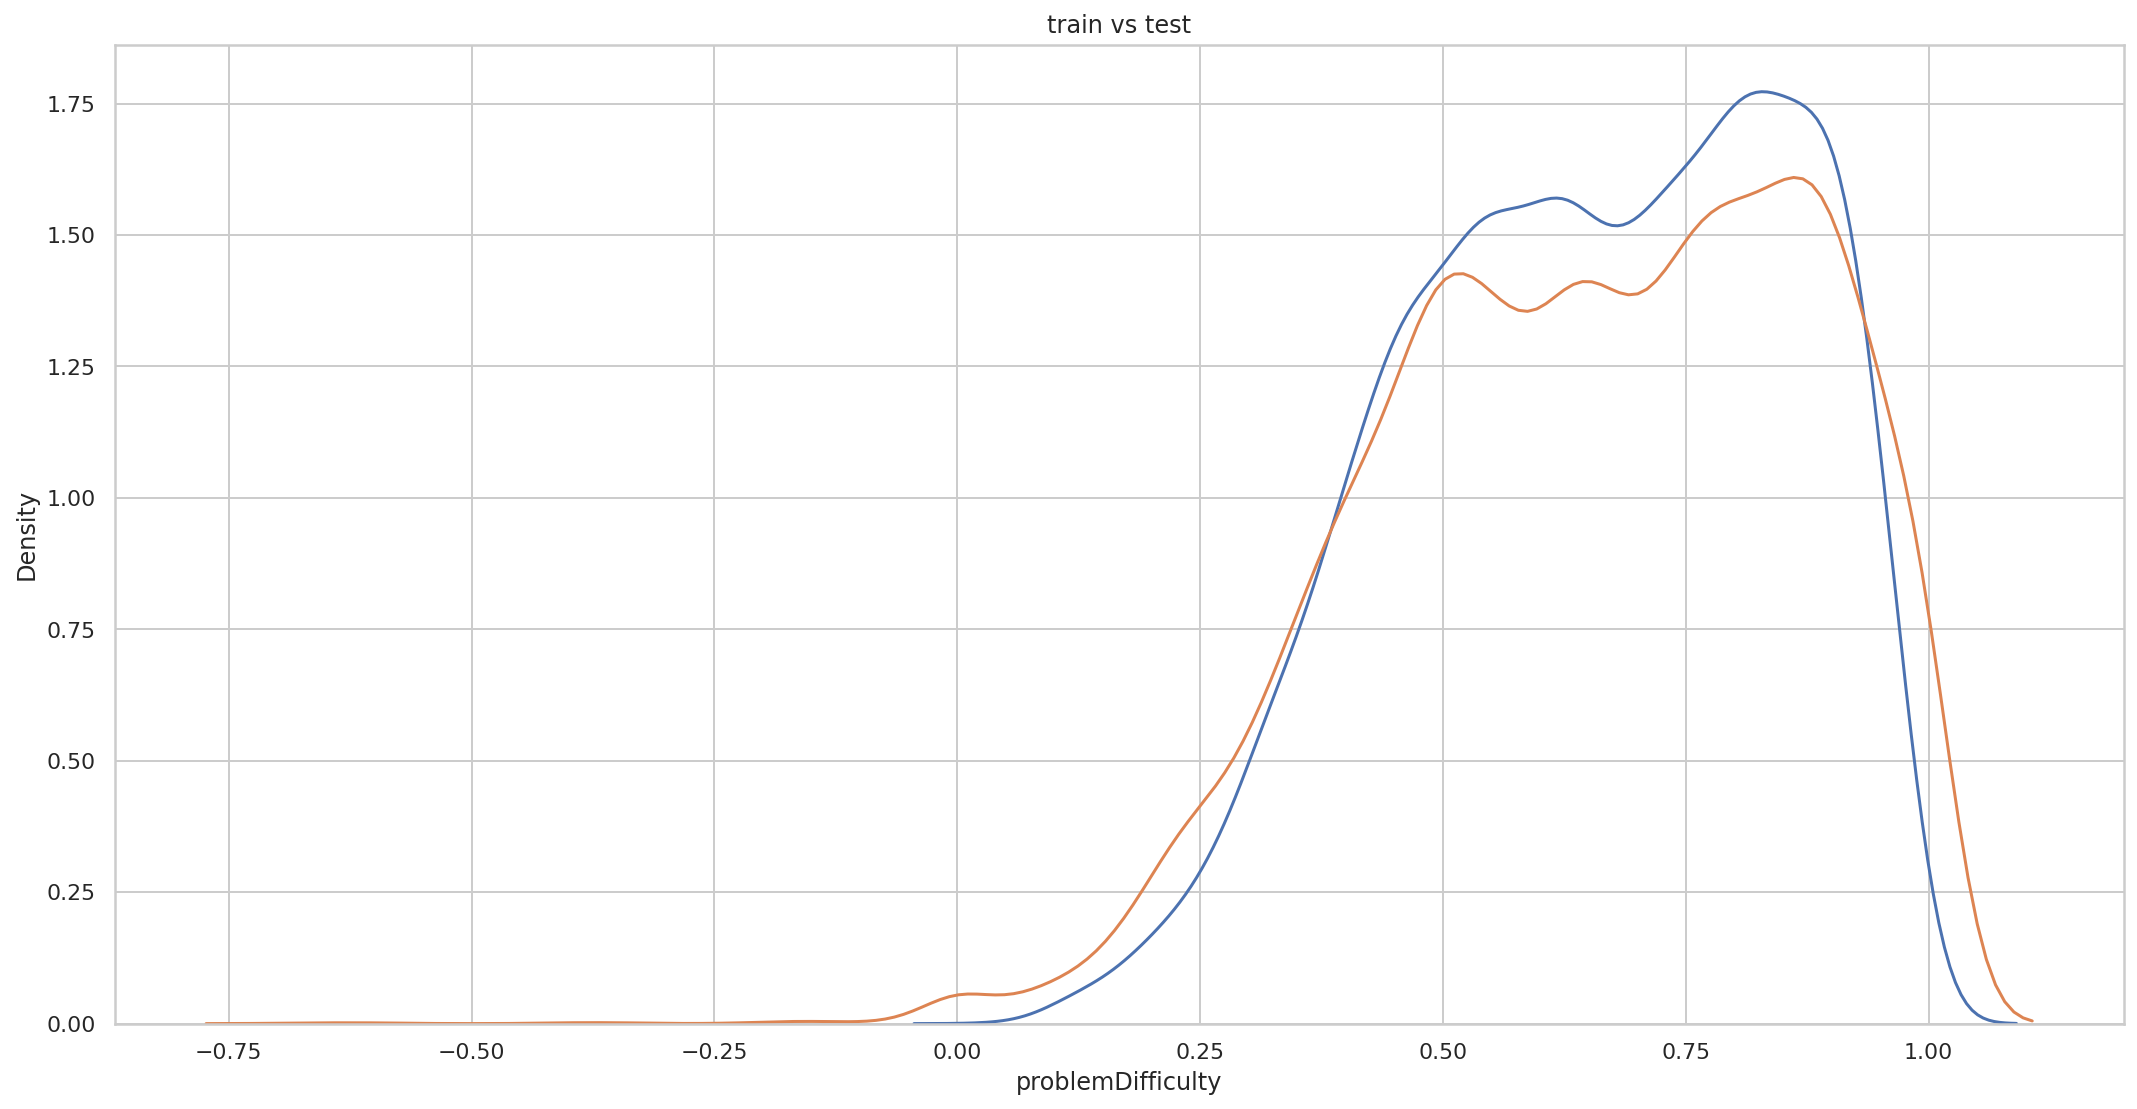

In [195]:
fig, axes = plt.subplots(1, 1, figsize=(18, 9))

axes.set_title("train vs test")

sns.kdeplot(data=tr_diff_by_asses, x="problemDifficulty", ax=axes)
sns.kdeplot(data=te_diff_by_asses, x="problemDifficulty", ax=axes)
plt.show()

### TestDataset 분포에 맞춰서 실행

코드 리팩토링 과정중 고치는 거라 코드가 이상한 부분이 많이 있음

- DataImbalnce 먼저 적용해보기로 합시다!!

In [76]:
from utils import get_args
from dkt_dataset import DKTDataset
from helper import get_dkt_dataset, get_dkt_loader, get_simple_data

In [77]:
args = get_args()

In [78]:
args.root_dir = "../loss_test/"
args.data_dir = "../../input/data/train_dataset/"

In [79]:
args.use_dynamic = True

In [80]:
fe = [MakeDifficultyByFirstClass]
cn = ["firstClassDifficulty"]
pre_e = {
    "min_max" : ["firstClassDifficulty"]
}

In [ ]:
grouped_train, grouped_valid, grouped_test = get_simple_data(args, fe, cn, pre_e)

In [82]:
len(grouped_train), len(grouped_valid)

(14429, 5310)

In [83]:
import torch
import numpy as np

In [84]:
grouped_total = np.concatenate([grouped_train, grouped_valid])

In [85]:
def _collate_fn(batches):
    """ key값으로 batch 형성 """
    new_batches = {k: [] for k in batches[0].keys()}

    # batch의 값들을 각 column끼리 그룹화
    for k in batches[0].keys():
        for batch in batches:
            if k == "seq_len":
                new_batches[k].append(batch[k])
                continue
            
            pre_padded = torch.zeros(20)
            pre_padded[-len(batch[k]) :] = batch[k]
            new_batches[k].append(pre_padded)
            

    for k in batches[0].keys():
        if k == "seq_len":
            continue
            
        new_batches[k] = torch.stack(new_batches[k])

    return new_batches

In [86]:
train_dataset = DKTDataset(grouped_train, args, args.columns, is_train=True)

In [87]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    num_workers=2,
    shuffle=True,
    batch_size=64,
    pin_memory=True,
    collate_fn=_collate_fn
)

In [88]:
proba.keys()

dict_keys(['6', '0', '1', '3', '2', '8', '4', '7', '5'])

In [97]:
# user_id, firstClass
from collections import defaultdict


def get_firstclass_distribution(train_loader, epochs=1, label_name=""):
    proba = defaultdict(list)
    
    for _ in range(epochs):
        for batches in train_loader:
            for fc2d, fcd2d in zip(batches['firstClass'], batches['firstClassDifficulty']):
                key = int(fc2d.tolist()[0])
                proba[key] += list(map(lambda x: max(x, 0), fcd2d.tolist()))
    
    new_df = {
        "firstClass" : [],
        "firstClassDifficulty" : [],
        "label" : []
    }

    for fc, fcd_list in proba.items():
        for fcd in fcd_list:
            new_df['firstClass'].append(str(fc + 1))
            new_df['firstClassDifficulty'].append(fcd)
            new_df['label'].append(label_name)

    new_df = pd.DataFrame(new_df)

    return new_df

In [98]:
n1_df = get_firstclass_distribution(train_loader, epochs=1, label_name="n_1")

In [99]:
n1_df.firstClass.unique()

array(['3', '5', '4', '1', '8', '7', '9', '2', '6'], dtype=object)

<AxesSubplot:ylabel='firstClassDifficulty'>

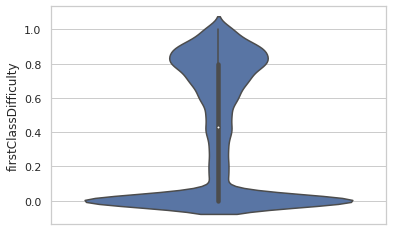

In [100]:
sns.violinplot(y=list(n1_df.groupby("firstClass").firstClassDifficulty)[0][1])

In [101]:
tt_data = tt_data[["firstClass", "firstClassDifficulty", "label"]]

In [102]:
nn_data = pd.concat([tt_data, n1_df], axis=0)

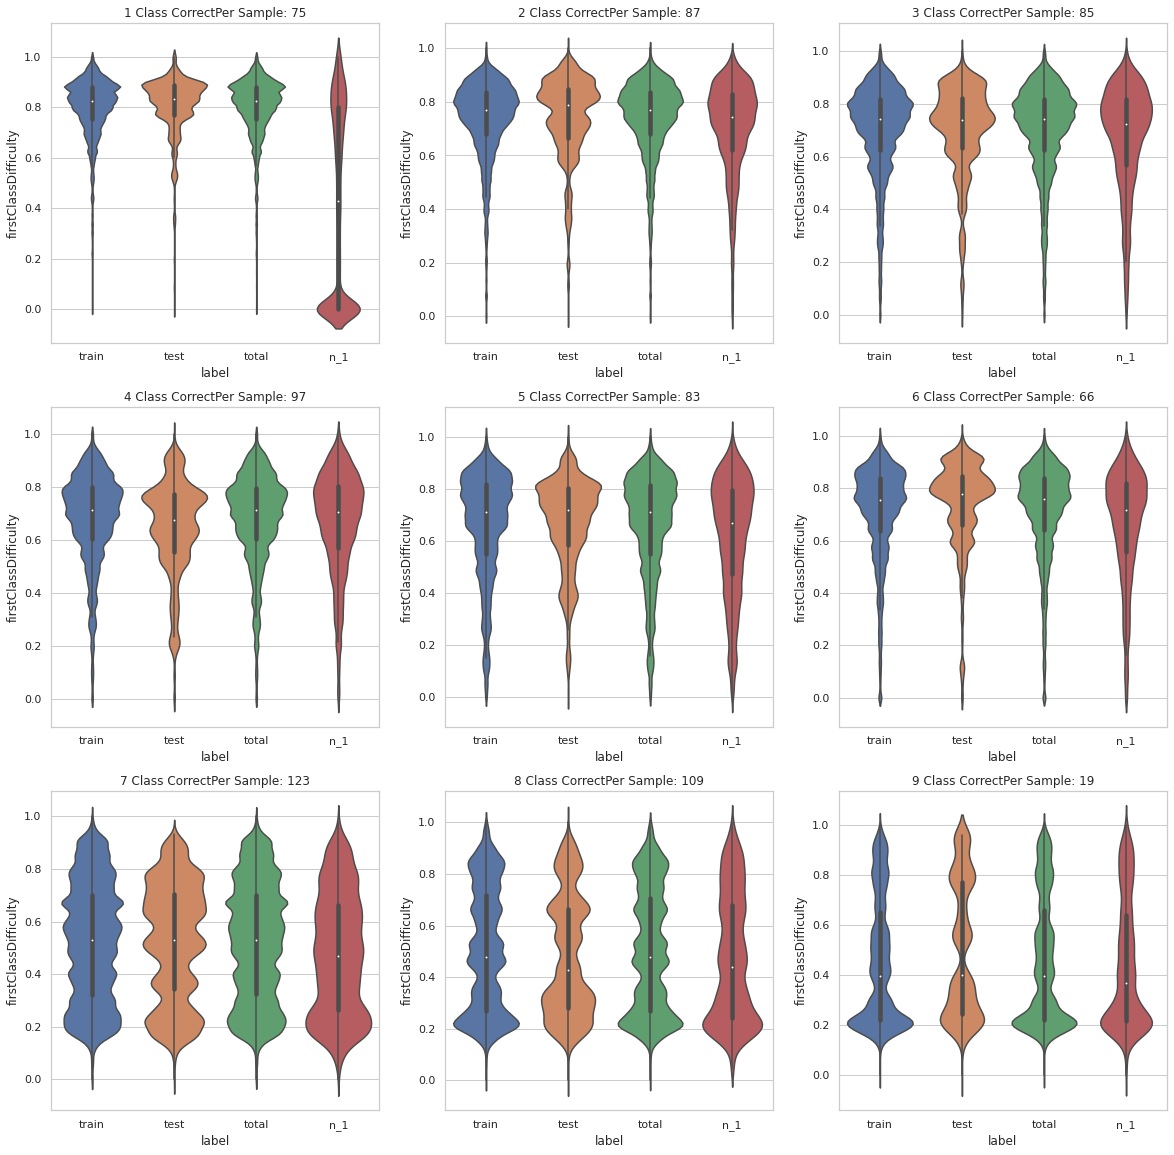

In [103]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for idx, g in enumerate(nn_data.groupby(["firstClass"])):
    axes[idx // 3][idx % 3].set_title(f"{idx+1} Class CorrectPer Sample: {counter[str(idx+1)]}")
    sns.violinplot(data=g[1], y="firstClassDifficulty", x="label", 
                ax=axes[idx // 3][idx % 3], whis=0.9)

In [104]:
n10_df = get_firstclass_distribution(train_loader, epochs=10, label_name="n_10")

In [105]:
nn_data = pd.concat([nn_data, n10_df], axis=0)

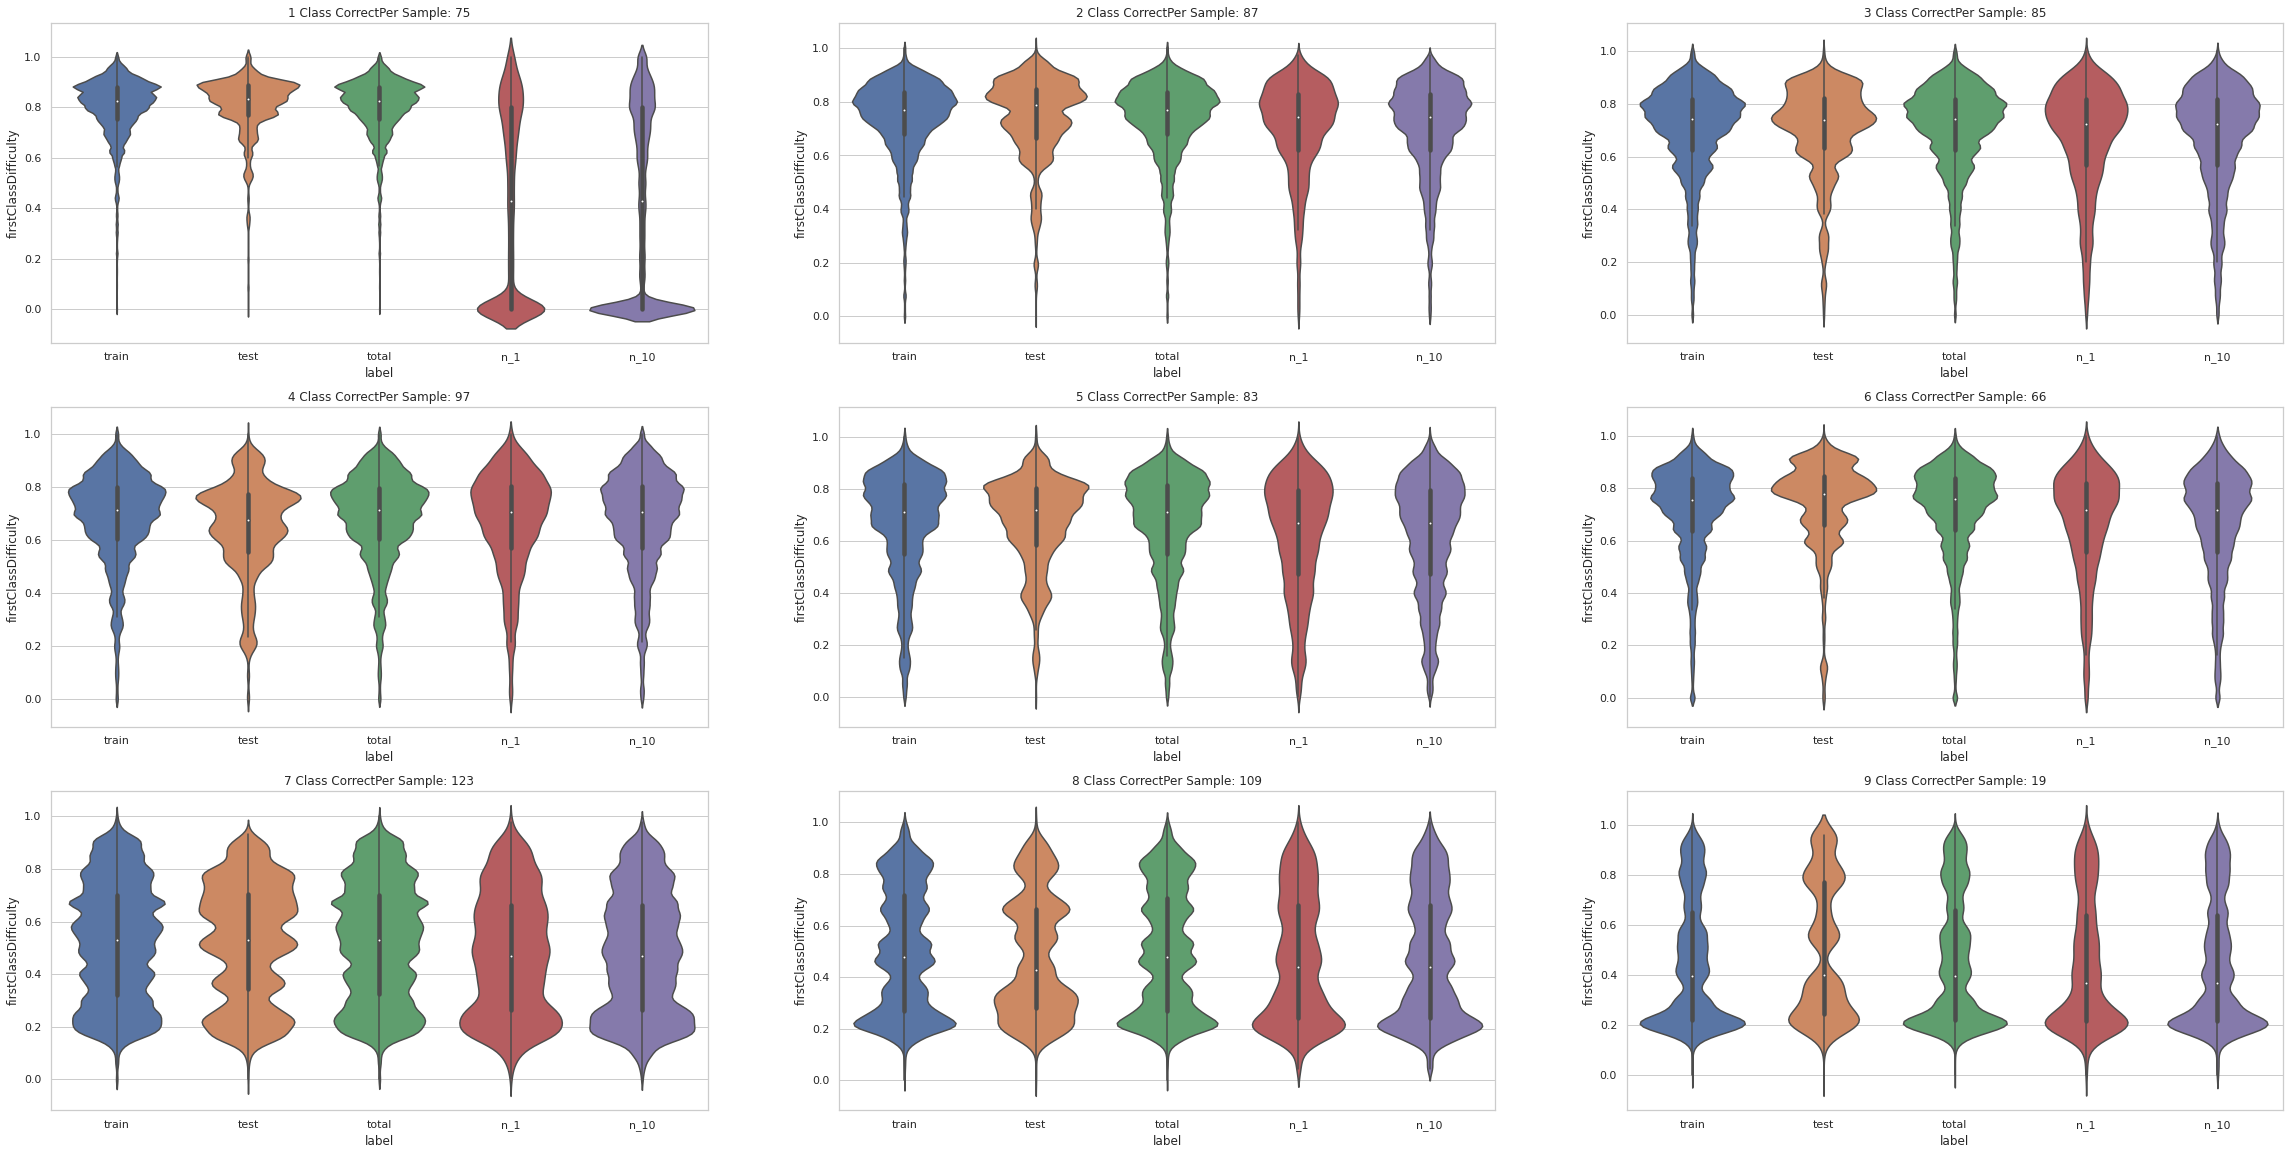

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for idx, g in enumerate(nn_data.groupby(["firstClass"])):
    axes[idx // 3][idx % 3].set_title(f"{idx+1} Class CorrectPer Sample: {counter[str(idx+1)]}")
    sns.violinplot(data=g[1], y="firstClassDifficulty", x="label", 
                ax=axes[idx // 3][idx % 3], whis=0.9)

In [112]:
valid_dataset = DKTDataset(grouped_valid, args, args.columns, is_train=False)
test_dataset = DKTDataset(grouped_test, args, args.columns, is_train=False)

In [113]:
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    num_workers=2,
    shuffle=False,
    batch_size=args.batch_size,
    pin_memory=True,
    collate_fn=_collate_fn,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    num_workers=2,
    shuffle=False,
    batch_size=args.batch_size,
    pin_memory=True,
    collate_fn=_collate_fn,
)

In [114]:
v1_df = get_firstclass_distribution(valid_loader, epochs=1, label_name="v_1")
t1_df = get_firstclass_distribution(test_loader, epochs=1, label_name="t_1")

In [118]:
nvt_df = pd.concat([n1_df, n10_df, v1_df, t1_df], axis=0)

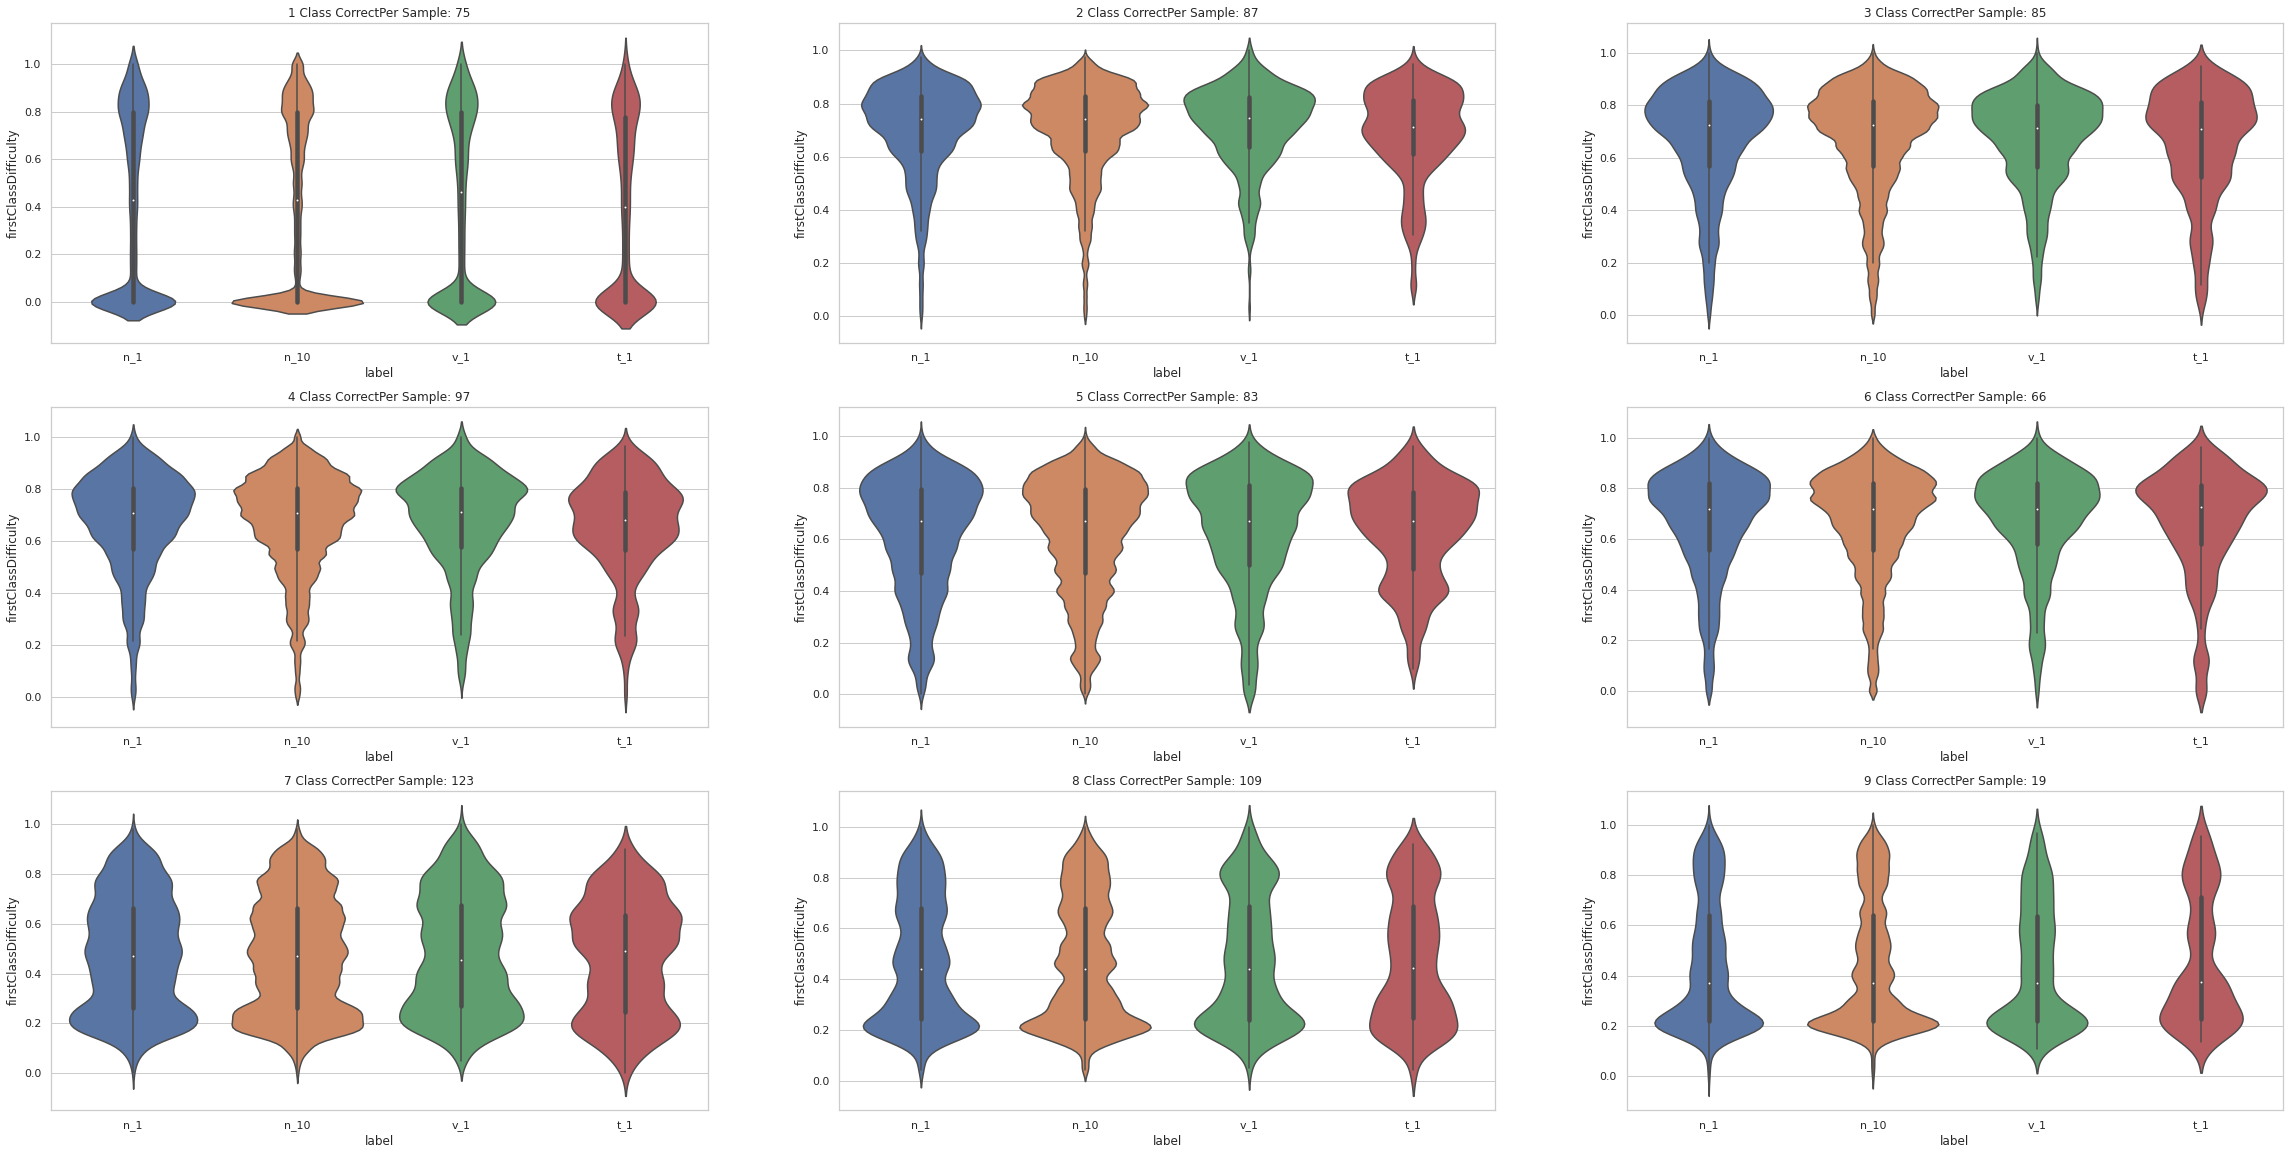

In [119]:
fig, axes = plt.subplots(3, 3, figsize=(40, 20))

for idx, g in enumerate(nvt_df.groupby(["firstClass"])):
    axes[idx // 3][idx % 3].set_title(f"{idx+1} Class CorrectPer Sample: {counter[str(idx+1)]}")
    sns.violinplot(data=g[1], y="firstClassDifficulty", x="label", 
                ax=axes[idx // 3][idx % 3], whis=0.9)

In [85]:
tt_data  = pd.concat([tt_data, new_df], axis=0)

아래 결과를 보면 Sampling 해서 나오는 분포가 Test분포와 매우 다른 것을 알 수 있다..

- 그럼 Valid에서 성능이 좋았던 것은...?
    - Valid에서도 use_dynamic 으로 뽑았을 때가 성능이 더 좋았음 -> 이상한 분포가 비슷해서 그랬던 거
    - use_dynamic 사용 안했을 때는 성능이 더 낮았음. -> 원래 Valid 분포 나름 유지가 되어서..
- Test는 분포가 완전히 달라지므로 성능이 하락한 것 같다.

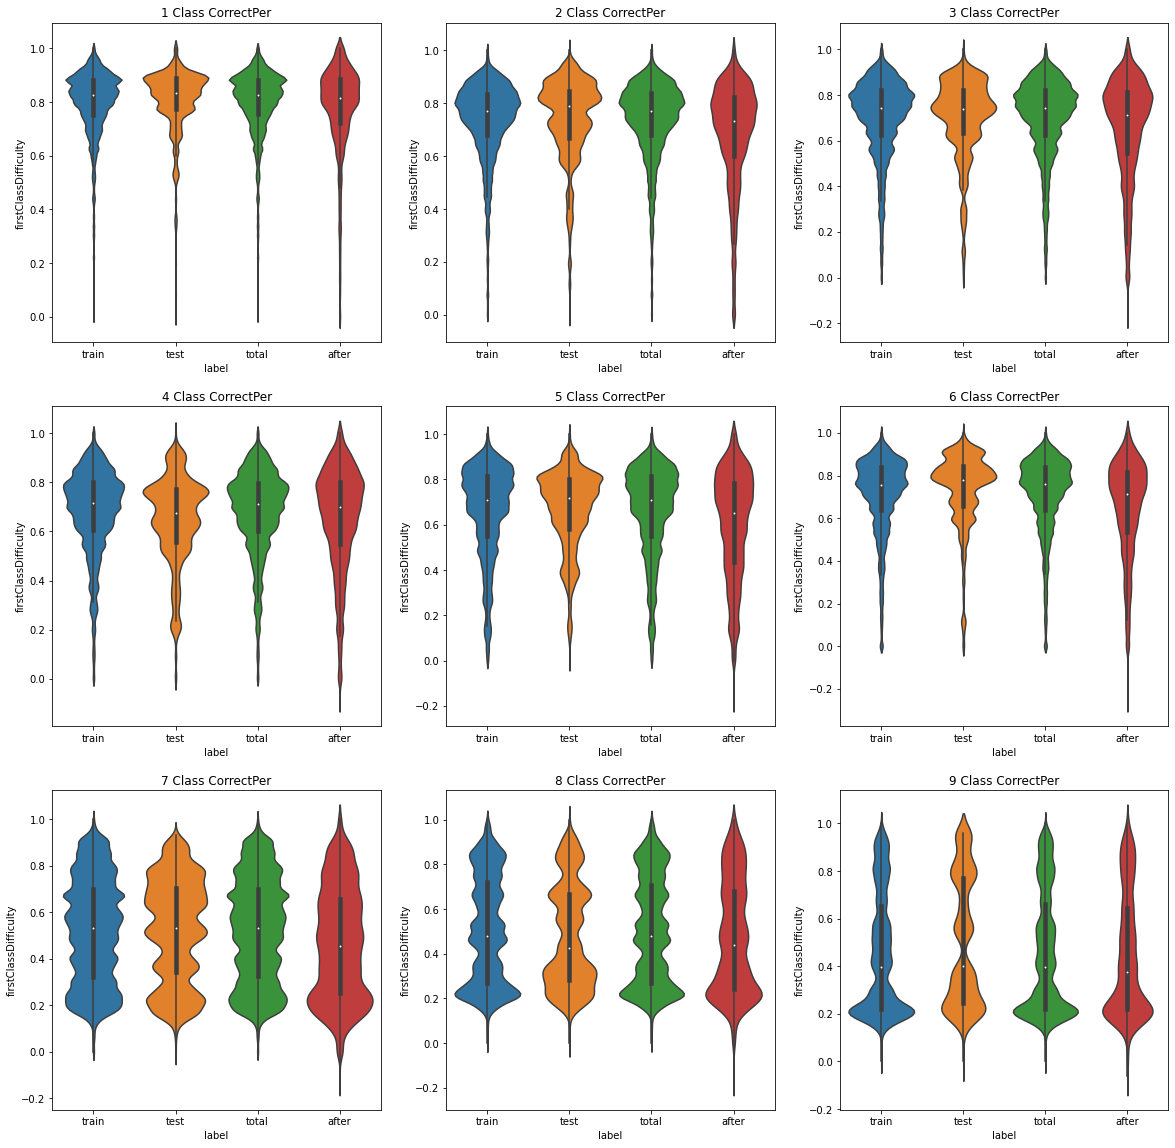

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for idx, g in enumerate(tt_data.groupby(["firstClass"])):  # 순서대로 나오는 이유가 뭘까..
    axes[idx // 3][idx % 3].set_title(f"{idx+1} Class CorrectPer Sample: {counter[str(idx+1)]}"
    sns.violinplot(data=g[1], y="firstClassDifficulty", x="label", 
                ax=axes[idx // 3][idx % 3], whis=0.9)

## Imbalanced Dataset

In [94]:
from typing import Callable

import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader, Sampler


class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices: list = None, num_samples: int = None, callback_get_label: Callable = None):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count: dict = {}

        for idx in self.indices:
            label = self._get_label(dataset, idx)
            label_to_count[label] = label_to_count.get(label, 0) + 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]

        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [194]:
class DKTDataset(torch.utils.data.Dataset):
    def __init__(self, data, args, columns, is_train=True):
        self.data = data
        self.args = args
        self.columns = columns
        self.is_train = is_train
        
        self.labels = self._make_label()
        
    def _make_label(self):
        labels = np.zeros(self.data.shape[0], dtype=np.int8)
        
        for idx, batch in enumerate(self.data):
            seq_len = batch[0].shape[0]
            label_idx = min(seq_len // 50, 24)
            labels[idx] = label_idx 
            
        return labels

    def _get_label(self, idx):
        return self.labels[idx]
    
    def __getitem__(self, index):
        row = self.data[index]

        # 각 data의 sequence length
        seq_len = len(row[0])
        datas = {key: row[idx] for idx, key in enumerate(self.columns)}

        # max seq len을 고려하여서 이보다 길면 자르고 아닐 경우 Random한 Sequence를 뽑아낸다.
        if seq_len > self.args.max_seq_len:
            if self.args.use_dynamic is True and self.is_train is True:
                s_idx = np.random.randint(0, seq_len - self.args.max_seq_len + 1)
                for key, value in datas.items():
                    datas[key] = value[s_idx : s_idx + self.args.max_seq_len]
            else:
                for key, value in datas.items():
                    datas[key] = value[-self.args.max_seq_len :]
            mask = np.ones(self.args.max_seq_len, dtype=np.int16)
        else:
            mask = np.zeros(self.args.max_seq_len, dtype=np.int16)
            mask[-seq_len:] = 1

        # mask도 columns 목록에 포함시킴
        datas["mask"] = mask

        # np.array -> torch.tensor 형변환
        for key, value in datas.items():
            datas[key] = torch.tensor(value)

        return datas

    def __len__(self):
        return len(self.data)

In [195]:
train_dataset = DKTDataset(grouped_train, args, args.columns, is_train=True)

In [196]:
def callback_get_label(dataset, idx):
    return dataset._get_label(idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    num_workers=2,
    # shuffle=True,
    batch_size=64,
    pin_memory=True,
    collate_fn=_collate_fn,
    sampler=ImbalancedDatasetSampler(train_dataset, callback_get_label=callback_get_label)
)

In [197]:
for v in batch['firstClass']:
    print(v)
    break

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [198]:
def get_firstclass_distribution(train_loader):
    proba = defaultdict(list)
    
    for batches in train_loader:
        for fc2d, fcd2d in zip(batches['firstClass'], batches['firstClassDifficulty']):
            key = str(int(fc2d.tolist()[0]))
            proba[key] += fcd2d.tolist()
        
    return proba

In [199]:
proba_after = get_firstclass_distribution(train_loader)

In [200]:
sampler_df = {
    "firstClass" : [],
    "firstClassDifficulty" : [],
    "label" : []
}

for fc, fcd_list in proba_after.items():
    for fcd in fcd_list:
        sampler_df['firstClass'].append(str(int(fc) + 1))
        sampler_df['firstClassDifficulty'].append(fcd)
        sampler_df['label'].append("sampler")

sampler_df = pd.DataFrame(sampler_df)

In [201]:
sampler_df.firstClass.unique()

array(['6', '9', '8', '7', '2', '1', '4', '3', '5'], dtype=object)

In [202]:
tt_data = tt_data[tt_data.label != "sampler"]

In [203]:
tt_data  = pd.concat([tt_data, sampler_df], axis=0)

In [204]:
tt_data.firstClass.unique()

array(['6', '8', '2', '4', '9', '3', '5', '1', '7'], dtype=object)

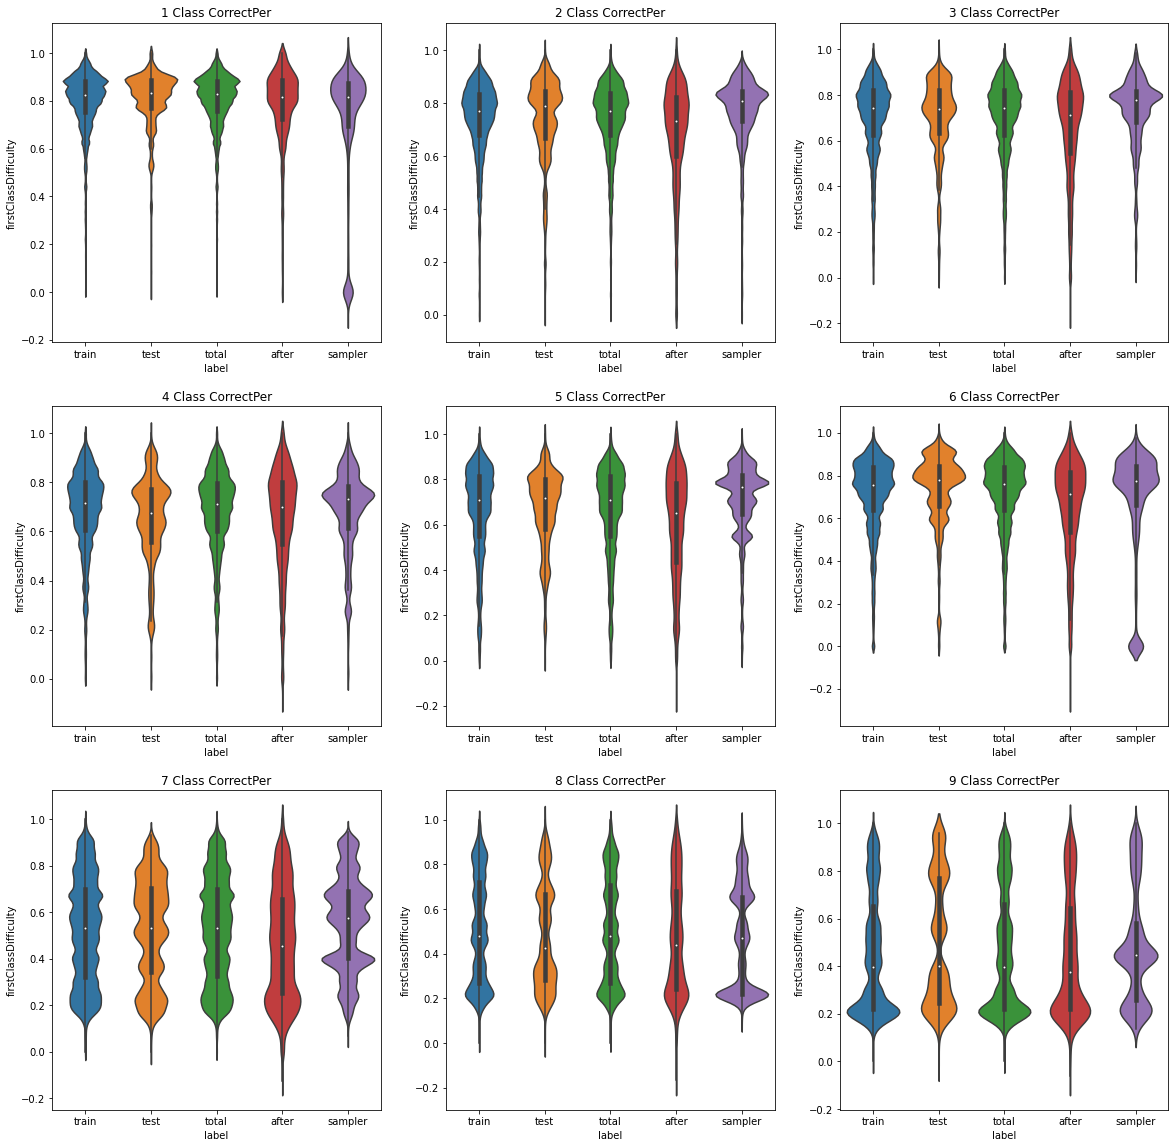

In [205]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for idx, g in enumerate(tt_data.groupby(["firstClass"])):  # 순서대로 나오는 이유가 뭘까..
    axes[idx // 3][idx % 3].set_title(f"{idx + 1} Class CorrectPer")
    sns.violinplot(data=g[1], y="firstClassDifficulty", x="label", 
                ax=axes[idx // 3][idx % 3], whis=0.9)

### 한 유저가 같은 문제를 2번 이상 푸는 경우

- 존재했다고 들었던 것 같은데

In [141]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [146]:
targets = [0, 0, 0, 1, 1, 1]
sample1 = np.array([0.1, 0.2, 0.7, 0.3, 0.8, 0.9])
sample2 = np.array([0.1, 0.3, 0.6, 0.4, 0.8, 0.9])

s1_auc = roc_auc_score(targets, sample1)
s1_acc = accuracy_score(targets, np.where(sample1 >= 0.5, 1, 0))

s2_auc = roc_auc_score(targets, sample2)
s2_acc = accuracy_score(targets, np.where(sample2 >= 0.5, 1, 0))

In [147]:
s1_auc, s2_auc, s1_acc, s2_acc

(0.888888888888889, 0.888888888888889, 0.6666666666666666, 0.6666666666666666)

In [163]:
ans_counter = Counter()

In [167]:
ans_counter.update([1, 0])

In [168]:
ans_counter

Counter({1: 2, 0: 2})

In [169]:
ans_counter = Counter()

for batch in valid_loader:
    ans_counter.update(list(map(int, batch['answerCode'][:, -1].tolist())))

In [170]:
ans_counter

Counter({1: 2629, 0: 2681})

In [173]:
sum(ans_counter.values())

5310

In [174]:
2681 / 5310, 2629 / 5310

(0.5048964218455744, 0.4951035781544256)

In [171]:
test_ans_counter = Counter()

for batch in test_loader:
    test_ans_counter.update(list(map(int, batch['answerCode'][:, -1].tolist())))

In [172]:
test_ans_counter

Counter({0: 663, -1: 744, 1: 580})

In [175]:
train_ans_counter = Counter()

for batch in train_loader:
    train_ans_counter.update(list(map(int, batch['answerCode'][:, -1].tolist())))

In [176]:
train_ans_counter

Counter({1: 8485, 0: 5944})

In [177]:
train_ans_counter = Counter()

for batch in train_loader:
    train_ans_counter.update(list(map(int, batch['answerCode'][:, -1].tolist())))

In [178]:
train_ans_counter

Counter({1: 8421, 0: 6008})

In [179]:
sum(train_ans_counter.values())

14429

In [180]:
8421 / 14429, 6008 / 14429

(0.5836163282278745, 0.4163836717721256)